In [1]:
import random

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score

from mmoe import MMoE

/var/folders/qt/75b2sv5s4_9cy8m59ly6kvkc0000gn/T/ipykernel_10095/3071140517.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
SEED = 1

# Fix numpy seed for reproducibility
np.random.seed(SEED)

# Fix random seed for reproducibility
random.seed(SEED)

# Fix TensorFlow graph-level seed for reproducibility
tf.random.set_seed(SEED)


# Simple callback to print out ROC-AUC
class ROCCallback(Callback):
    def __init__(self, training_data, validation_data, test_data):
        self.train_X = training_data[0]
        self.train_Y = training_data[1]
        self.validation_X = validation_data[0]
        self.validation_Y = validation_data[1]
        self.test_X = test_data[0]
        self.test_Y = test_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        train_prediction = self.model.predict(self.train_X)
        validation_prediction = self.model.predict(self.validation_X)
        test_prediction = self.model.predict(self.test_X)

        # Iterate through each task and output their ROC-AUC across different datasets
        for index, output_name in enumerate(self.model.output_names):
            train_roc_auc = roc_auc_score(self.train_Y[index], train_prediction[index])
            validation_roc_auc = roc_auc_score(
                self.validation_Y[index], validation_prediction[index]
            )
            test_roc_auc = roc_auc_score(self.test_Y[index], test_prediction[index])
            print(
                "ROC-AUC-{}-Train: {} ROC-AUC-{}-Validation: {} ROC-AUC-{}-Test: {}".format(
                    output_name,
                    round(train_roc_auc, 4),
                    output_name,
                    round(validation_roc_auc, 4),
                    output_name,
                    round(test_roc_auc, 4),
                )
            )

        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return


def data_preparation():
    # The column names are from
    # https://www2.1010data.com/documentationcenter/prod/Tutorials/MachineLearningExamples/CensusIncomeDataSet.html
    column_names = [
        "age",
        "class_worker",
        "det_ind_code",
        "det_occ_code",
        "education",
        "wage_per_hour",
        "hs_college",
        "marital_stat",
        "major_ind_code",
        "major_occ_code",
        "race",
        "hisp_origin",
        "sex",
        "union_member",
        "unemp_reason",
        "full_or_part_emp",
        "capital_gains",
        "capital_losses",
        "stock_dividends",
        "tax_filer_stat",
        "region_prev_res",
        "state_prev_res",
        "det_hh_fam_stat",
        "det_hh_summ",
        "instance_weight",
        "mig_chg_msa",
        "mig_chg_reg",
        "mig_move_reg",
        "mig_same",
        "mig_prev_sunbelt",
        "num_emp",
        "fam_under_18",
        "country_father",
        "country_mother",
        "country_self",
        "citizenship",
        "own_or_self",
        "vet_question",
        "vet_benefits",
        "weeks_worked",
        "year",
        "income_50k",
    ]

    # Load the dataset in Pandas
    train_df = pd.read_csv(
        "data/census-income.data.gz",
        delimiter=",",
        header=None,
        index_col=None,
        names=column_names,
    )
    other_df = pd.read_csv(
        "data/census-income.test.gz",
        delimiter=",",
        header=None,
        index_col=None,
        names=column_names,
    )

    # First group of tasks according to the paper
    label_columns = ["income_50k", "marital_stat"]

    # One-hot encoding categorical columns
    categorical_columns = [
        "class_worker",
        "det_ind_code",
        "det_occ_code",
        "education",
        "hs_college",
        "major_ind_code",
        "major_occ_code",
        "race",
        "hisp_origin",
        "sex",
        "union_member",
        "unemp_reason",
        "full_or_part_emp",
        "tax_filer_stat",
        "region_prev_res",
        "state_prev_res",
        "det_hh_fam_stat",
        "det_hh_summ",
        "mig_chg_msa",
        "mig_chg_reg",
        "mig_move_reg",
        "mig_same",
        "mig_prev_sunbelt",
        "fam_under_18",
        "country_father",
        "country_mother",
        "country_self",
        "citizenship",
        "vet_question",
    ]
    train_raw_labels = train_df[label_columns]
    other_raw_labels = other_df[label_columns]
    transformed_train = pd.get_dummies(
        train_df.drop(label_columns, axis=1), columns=categorical_columns
    )
    transformed_other = pd.get_dummies(
        other_df.drop(label_columns, axis=1), columns=categorical_columns
    )

    # Filling the missing column in the other set
    transformed_other["det_hh_fam_stat_ Grandchild <18 ever marr not in subfamily"] = 0

    # One-hot encoding categorical labels
    train_income = to_categorical(
        (train_raw_labels.income_50k == " 50000+.").astype(int), num_classes=2
    )
    train_marital = to_categorical(
        (train_raw_labels.marital_stat == " Never married").astype(int), num_classes=2
    )
    other_income = to_categorical(
        (other_raw_labels.income_50k == " 50000+.").astype(int), num_classes=2
    )
    other_marital = to_categorical(
        (other_raw_labels.marital_stat == " Never married").astype(int), num_classes=2
    )

    dict_outputs = {"income": train_income.shape[1], "marital": train_marital.shape[1]}
    dict_train_labels = {"income": train_income, "marital": train_marital}
    dict_other_labels = {"income": other_income, "marital": other_marital}
    output_info = [(dict_outputs[key], key) for key in sorted(dict_outputs.keys())]

    # Split the other dataset into 1:1 validation to test according to the paper
    validation_indices = transformed_other.sample(
        frac=0.5, replace=False, random_state=SEED
    ).index
    test_indices = list(set(transformed_other.index) - set(validation_indices))
    validation_data = transformed_other.iloc[validation_indices]
    validation_label = [
        dict_other_labels[key][validation_indices]
        for key in sorted(dict_other_labels.keys())
    ]
    test_data = transformed_other.iloc[test_indices]
    test_label = [
        dict_other_labels[key][test_indices] for key in sorted(dict_other_labels.keys())
    ]
    train_data = transformed_train
    train_label = [dict_train_labels[key] for key in sorted(dict_train_labels.keys())]

    return (
        train_data,
        train_label,
        validation_data,
        validation_label,
        test_data,
        test_label,
        output_info,
    )

In [3]:
# Load the data
(
    train_data,
    train_label,
    validation_data,
    validation_label,
    test_data,
    test_label,
    output_info,
) = data_preparation()
num_features = train_data.shape[1]

print("Training data shape = {}".format(train_data.shape))
print("Validation data shape = {}".format(validation_data.shape))
print("Test data shape = {}".format(test_data.shape))

Training data shape = (199523, 499)
Validation data shape = (49881, 499)
Test data shape = (49881, 499)


In [4]:
# Set up the input layer
input_layer = Input(shape=(num_features,))

# Set up MMoE layer
mmoe_layers = MMoE(units=4, num_experts=8, num_tasks=2)(input_layer)

output_layers = []

/Users/andrewmaguire/Documents/GitHub/keras-mmoe/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [5]:
# Build tower layer from MMoE layer
for index, task_layer in enumerate(mmoe_layers):
    tower_layer = Dense(
        units=8, activation="relu", kernel_initializer=VarianceScaling()
    )(task_layer)
    output_layer = Dense(
        units=output_info[index][0],
        name=output_info[index][1],
        activation="softmax",
        kernel_initializer=VarianceScaling(),
    )(tower_layer)
    output_layers.append(output_layer)

# Compile model
model = Model(inputs=[input_layer], outputs=output_layers)
adam_optimizer = Adam()
model.compile(
    loss={"income": "binary_crossentropy", "marital": "binary_crossentropy"},
    optimizer=adam_optimizer,
    metrics=["accuracy"],
)

In [6]:
# Print out model architecture summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 499)]                0         []                            
                                                                                                  
 m_mo_e (MMoE)               [(None, 4),                  24000     ['input_1[0][0]']             
                              (None, 4)]                                                          
                                                                                                  
 dense (Dense)               (None, 8)                    40        ['m_mo_e[0][0]']              
                                                                                                  
 dense_1 (Dense)             (None, 8)                    40        ['m_mo_e[0][1]']          

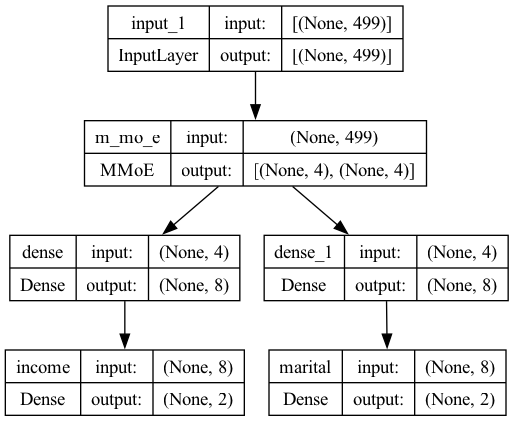

In [8]:
# plot the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [10]:
# Train the model
model.fit(
    x=train_data,
    y=train_label,
    validation_data=(validation_data, validation_label),
    callbacks=[
        ROCCallback(
            training_data=(train_data, train_label),
            validation_data=(validation_data, validation_label),
            test_data=(test_data, test_label),
        )
    ],
    epochs=25,
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).